In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import clean_data
import random
import train
from tqdm.notebook import tqdm

init_cols = ['BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE', 'ECCENTRICITY', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY',
             'MEAN_MOTION', 'NORAD_CAT_ID', 'EPOCH', 'SUNSPOTS_1D', 'SUNSPOTS_3D', 'SUNSPOTS_7D',
             'AIR_MONTH_AVG_TEMP', 'WATER_MONTH_AVG_TEMP',
            ]


def load_raw(name=None):
    if not name:
        train_df = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/../3_min/train.pkl' ) # Time: 25.7s
        test_df = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/../3_min/test.pkl' ) # Time: 5
        return {'train': train_df, 'test': test_df}
    elif name == 'train':
        return {name: pd.read_pickle(os.environ['GP_HIST_PATH'] + '/../3_min/train.pkl' )}
    elif name == 'test':
        return {name: pd.read_pickle(os.environ['GP_HIST_PATH'] + '/../3_min/test.pkl' )}

def create_save(perc, name=None):
    #df_in = load_raw(name)
    
    if not name:
        names = ['train','test']
    else:
        names = [name]

    df_out = []
    #for name, df in df_in.items():
    for name in names:
        print(f'>>> Loading {name} raw data')
        df = pd.read_pickle(os.environ['GP_HIST_PATH'] + f'/../3_min/{name}.pkl' )[init_cols].reset_index(drop=True)
        
        print(f'>>> Normalizing {name} data...')
        df = clean_data.normalize_all_columns(df) # 53.4s

        print(f'>>> Building {name} index map...')
        try:
            idx_map = clean_data.load_index_map(name=name, path='data')
        except:
            idx_map = clean_data.create_index_map(df, write=True, name=name, path='data') # 3min 29s

        print(f'>>> Building {name} inputs and labels')
        X,y = clean_data.build_xy(df, idx_map) # 59min 41s
        X = clean_data.normalize_epoch_diff(X, drop_epoch=False) # 19s
        #all_X = []
        #all_y = []
        #batch_size = 1000000
        #batches = [idx_map[i:i+batch_size] for i in range(0, len(idx_map), batch_size)]
        #for batch in tqdm(batches):
        #    X,y = clean_data.build_xy(df, batch) # 59min 41s
        #    X = clean_data.normalize_epoch_diff(X, drop_epoch=False) # 19s
        #    all_X.append(X)
        #    all_y.append(y)
            
        #print(f'>>> Concate {name} all')
        #X = pd.concate(all_X)
        #y = pd.concate(all_y)

        print(f'>>> Saving {name} data')
        X.to_pickle(os.environ['GP_HIST_PATH'] + f'/cleaned/x_{name}1.pkl')
        y.to_pickle(os.environ['GP_HIST_PATH'] + f'/cleaned/y_{name}1.pkl')
        df_out.extend([X,y])
    
    return df_out

def load(perc, force_update=False):
    if not force_update:
        print('>>> Loading data')
        
        X_train = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/cleaned/x_train1.pkl')
        y_train = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/cleaned/y_train1.pkl')
        X_test = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/cleaned/x_test1.pkl')
        y_test = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/cleaned/y_test1.pkl')
        return X_train, y_train, X_test, y_test
    else:
        return create_save(perc)
        

perc = 0.05
force_update = False

X_train, y_train, X_test, y_test = load(perc, force_update)
print(f'>>> Complete')

>>> Loading train raw data
>>> Normalizing train data...
>>> Building train index map...
>>> Building train inputs and labels
>>> Saving train data
>>> Loading test raw data
>>> Normalizing test data...
>>> Building test index map...


Creating index map:   0%|          | 0/2702 [00:00<?, ?it/s]

>>> Building test inputs and labels
>>> Saving test data
>>> Complete


In [2]:
pd.set_option('display.max_columns', 999)

# Train on only 2 rows:
# X_train = X_train.iloc[0:2]
# y_train = y_train.iloc[0:2]

print(f'Train: rows={len(X_train)}')
display(X_train.head())
display(y_train.head())


print(f'Test: rows={len(X_test)}')
display(X_test.head())
display(y_test.head())

Train: rows=48769686


,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION,SUNSPOTS_1D,SUNSPOTS_3D,SUNSPOTS_7D,AIR_MONTH_AVG_TEMP,WATER_MONTH_AVG_TEMP,year,month_sin,month_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,ms_sin,ms_cos,year_y,month_sin_y,month_cos_y,hour_sin_y,hour_cos_y,minute_sin_y,minute_cos_y,second_sin_y,second_cos_y,ms_sin_y,ms_cos_y,EPOCH,EPOCH_y,epoch_day_diff,epoch_sec_diff,epoch_ms_diff
0,0.000552,0.345682,0.504573,0.309078,0.462565,0.543816,0.170611,0.168,0.177333,0.194571,0.760,0.677,0.258065,-0.5,-8.660254e-01,0.866025,-0.500000,-0.669131,-7.431448e-01,-0.309017,-0.951057,-0.356130,-0.934436,0.451613,-0.500000,-8.660254e-01,0.965926,0.258819,-0.406737,-9.135455e-01,-0.309017,-0.951057,0.486504,-0.873678,1998-08-01 08:37:33.557952,2004-08-10 05:34:33.419136,-0.192783,0.127083,0.138816
1,0.002696,0.345787,0.795126,0.282100,0.802900,0.176510,0.183388,0.198,0.167333,0.135429,0.478,0.444,0.451613,-0.5,-8.660254e-01,0.965926,0.258819,-0.406737,-9.135455e-01,-0.309017,-0.951057,0.486504,-0.873678,0.645161,-1.000000,-1.836970e-16,-0.500000,0.866025,0.207912,9.781476e-01,0.866025,0.500000,-0.937093,-0.349080,2004-08-10 05:34:33.419136,2010-10-05 22:02:10.693247,-0.196899,0.314144,0.725889
2,0.001587,0.345651,0.601665,0.293362,0.188529,0.832906,0.185565,0.026,0.042000,0.065429,0.746,0.611,0.645161,-1.0,-1.836970e-16,-0.500000,0.866025,0.207912,9.781476e-01,0.866025,0.500000,-0.937093,-0.349080,0.225806,-0.500000,8.660254e-01,0.500000,-0.866025,-0.669131,-7.431448e-01,0.309017,0.951057,-0.005228,-0.999986,2010-10-05 22:02:10.693247,1997-12-16 10:37:03.500832,0.409565,0.475775,0.192415
3,0.000061,0.345729,0.013095,0.314878,0.327711,0.695316,0.170153,0.094,0.106000,0.137429,0.656,0.634,0.225806,-0.5,8.660254e-01,0.500000,-0.866025,-0.669131,-7.431448e-01,0.309017,0.951057,-0.005228,-0.999986,0.451613,0.500000,-8.660254e-01,-0.707107,-0.707107,-1.000000,-1.836970e-16,0.951057,0.309017,0.116951,-0.993138,1997-12-16 10:37:03.500832,2004-06-26 15:45:12.481344,-0.208899,0.786007,0.019488
4,-0.000221,0.345819,0.095622,0.281552,0.775454,0.202845,0.183247,0.104,0.126000,0.190286,0.445,0.372,0.451613,0.5,-8.660254e-01,-0.707107,-0.707107,-1.000000,-1.836970e-16,0.951057,0.309017,0.116951,-0.993138,0.354839,-0.866025,5.000000e-01,-0.258819,0.965926,0.406737,9.135455e-01,0.743145,0.669131,0.977355,-0.211608,2004-06-26 15:45:12.481344,2001-11-24 23:04:08.283935,0.082684,0.695185,0.197409


,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.345787,0.795126,0.282100,0.802900,0.176510,0.183388
1,0.345651,0.601665,0.293362,0.188529,0.832906,0.185565
2,0.345729,0.013095,0.314878,0.327711,0.695316,0.170153
3,0.345819,0.095622,0.281552,0.775454,0.202845,0.183247
4,0.345667,0.452867,0.305143,0.198696,0.824191,0.178082


Test: rows=9626509


,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION,SUNSPOTS_1D,SUNSPOTS_3D,SUNSPOTS_7D,AIR_MONTH_AVG_TEMP,WATER_MONTH_AVG_TEMP,year,month_sin,month_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,ms_sin,ms_cos,year_y,month_sin_y,month_cos_y,hour_sin_y,hour_cos_y,minute_sin_y,minute_cos_y,second_sin_y,second_cos_y,ms_sin_y,ms_cos_y,EPOCH,EPOCH_y,epoch_day_diff,epoch_sec_diff,epoch_ms_diff
0,0.000066,0.552560,0.844743,0.027294,0.152717,0.849376,0.302420,0.098,0.084667,0.079714,0.686,0.529,0.645161,-8.660254e-01,-5.000000e-01,0.707107,0.707107,0.994522,1.045285e-01,0.406737,-0.913545,0.771022,0.636809,0.032258,-1.000000e+00,-1.836970e-16,0.258819,0.965926,-0.866025,-5.000000e-01,0.743145,-0.669131,0.983252,0.182250,2010-09-26 03:14:26.140127,1991-10-28 01:40:22.220831,0.605063,0.065312,0.919296
1,0.000399,0.549384,0.893867,0.027567,0.830220,0.168185,0.299772,0.604,0.555333,0.428286,0.343,0.319,0.032258,-1.000000e+00,-1.836970e-16,0.258819,0.965926,-0.866025,-5.000000e-01,0.743145,-0.669131,0.983252,0.182250,0.258065,1.224647e-16,-1.000000e+00,-0.500000,0.866025,0.309017,9.510565e-01,-0.500000,-0.866025,-0.278750,-0.960364,1991-10-28 01:40:22.220831,1998-07-21 22:03:35.544960,-0.215381,0.150532,0.675871
2,0.000113,0.550478,0.434652,0.027727,0.307266,0.695125,0.300464,0.226,0.176000,0.168000,0.728,0.679,0.258065,1.224647e-16,-1.000000e+00,-0.500000,0.866025,0.309017,9.510565e-01,-0.500000,-0.866025,-0.278750,-0.960364,0.967742,-1.000000e+00,-1.836970e-16,-0.965926,0.258819,1.000000,6.123234e-17,-0.866025,-0.500000,0.904827,-0.425779,1998-07-21 22:03:35.544960,2020-10-01 19:15:40.320000,-0.710169,0.116609,0.224960
3,0.000083,0.549868,0.909722,0.026493,0.720838,0.455548,0.303157,0.000,0.000000,0.001143,0.926,0.775,0.967742,-1.000000e+00,-1.836970e-16,-0.965926,0.258819,1.000000,6.123234e-17,-0.866025,-0.500000,0.904827,-0.425779,0.258065,-5.000000e-01,8.660254e-01,-0.866025,0.500000,0.978148,-2.079117e-01,0.994522,-0.104528,-0.999179,-0.040503,2020-10-01 19:15:40.320000,1998-12-16 20:17:16.743552,0.697118,0.957211,0.576448
4,0.000173,0.550629,0.835091,0.027632,0.199008,0.803393,0.300522,0.174,0.208667,0.255143,0.654,0.568,0.258065,-5.000000e-01,8.660254e-01,-0.866025,0.500000,0.978148,-2.079117e-01,0.994522,-0.104528,-0.999179,-0.040503,0.741935,1.224647e-16,-1.000000e+00,0.866025,0.500000,-0.913545,4.067366e-01,0.500000,0.866025,0.008243,0.999966,1998-12-16 20:17:16.743552,2013-07-15 04:49:05.001312,-0.466410,0.644572,0.742240


,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.549384,0.893867,0.027567,0.830220,0.168185,0.299772
1,0.550478,0.434652,0.027727,0.307266,0.695125,0.300464
2,0.549868,0.909722,0.026493,0.720838,0.455548,0.303157
3,0.550629,0.835091,0.027632,0.199008,0.803393,0.300522
4,0.551757,0.710351,0.027081,0.524991,0.568024,0.302666


In [3]:
import train

configurations = {
    'model_identifier' : "full_local_1",
    'model_path' : './data',
    'device' : 'cuda',
    'random_seed' : 0,
    'lr' : 0.01,
    'momentum' : 0.9,
    'weight_decay' : 1e-6,
    'max_epochs' : 5,
    'do_validate' : True,
    'model_definition' : {
        'layer1' : 50, 'relu1' : True, #'drop1' : 0.2,
        'layer2' : 30, 'relu2' : True, #'drop2' : 0.2,
        'layer3' : 30, 'relu3' : True, #'drop3' : 0.2,
        'layer4' : 30, 'relu4' : True, #'drop4' : 0.5,
        'layer5' : 20, 'relu5' : True, #'drop5' : 0.5,
        'layer6' : 20, 'relu6' : True, #'drop6' : 0.5,
        'layer7' : 20, 'relu7' : True, #'drop7' : 0.5,
        'layer8' : 10, 'relu8' : True, #'drop8' : 0.5,
        'layer9' : 10, 'relu9' : True, #'drop9' : 0.5,
    },
    'train_params' : {
        'batch_size': 2000,
        'shuffle': True,
        'num_workers': 5,
        'pin_memory': True,
    },
    'test_params' : {
        'batch_size': 20000,
        'num_workers': 5,
        'pin_memory': True,
    },
}

In [4]:
cols = ['BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE', 'ECCENTRICITY',
       'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'MEAN_MOTION', 'SUNSPOTS_1D',
       'SUNSPOTS_3D', 'SUNSPOTS_7D', 'AIR_MONTH_AVG_TEMP',
       'WATER_MONTH_AVG_TEMP', 'year', 'month_sin', 'month_cos', 'hour_sin',
       'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos',
       'ms_sin', 'ms_cos', 'year_y', 'month_sin_y', 'month_cos_y',
       'hour_sin_y', 'hour_cos_y', 'minute_sin_y', 'minute_cos_y',
       'second_sin_y', 'second_cos_y', 'ms_sin_y', 'ms_cos_y',
       'epoch_day_diff', 'epoch_sec_diff', 'epoch_ms_diff']

# cols = ['BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE', 'ECCENTRICITY',
#        'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'MEAN_MOTION', 'year', 'month_sin',
#        'month_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos',
#        'second_sin', 'second_cos', 'ms_sin', 'ms_cos', 'year_y', 'month_sin_y',
#        'month_cos_y', 'hour_sin_y', 'hour_cos_y', 'minute_sin_y',
#        'minute_cos_y', 'second_sin_y', 'second_cos_y', 'ms_sin_y', 'ms_cos_y',
#        'epoch_day_diff', 'epoch_sec_diff', 'epoch_ms_diff']

model, mean_losses = train.train_model(X_train[cols], y_train, X_test[cols], y_test, configurations, force_train=True)

New model created
NNModelEx(
  (net): Sequential(
    (0): Linear(in_features=37, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=30, bias=True)
    (7): ReLU()
    (8): Linear(in_features=30, out_features=20, bias=True)
    (9): ReLU()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): ReLU()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): ReLU()
    (14): Linear(in_features=20, out_features=10, bias=True)
    (15): ReLU()
    (16): Linear(in_features=10, out_features=10, bias=True)
    (17): ReLU()
    (18): Linear(in_features=10, out_features=6, bias=True)
  )
)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/24385 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/24385 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/24385 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/24385 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/24385 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

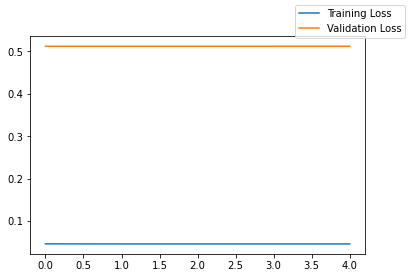

In [5]:
if not 'mean_losses' in locals():
    model, _, _, mean_losses, _ = train.load_model_with_config(configurations)
    
tl, vl = zip(*mean_losses)

fig,ax = plt.subplots()
ax.plot(tl, label="Training Loss")
ax.plot(vl, label="Validation Loss")

fig.legend()
plt.show()

In [9]:
%%time
import train

cols = ['BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE', 'ECCENTRICITY',
       'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'MEAN_MOTION', 'year', 'month_sin',
       'month_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos',
       'second_sin', 'second_cos', 'ms_sin', 'ms_cos', 'year_y', 'month_sin_y',
       'month_cos_y', 'hour_sin_y', 'hour_cos_y', 'minute_sin_y',
       'minute_cos_y', 'second_sin_y', 'second_cos_y', 'ms_sin_y', 'ms_cos_y',
       'epoch_day_diff', 'epoch_sec_diff', 'epoch_ms_diff']

model = train.create_model(len(cols), len(y_train.columns),
                           layer1=50, relu1=True, #drop1=0.2,
                           layer2=30, relu2=True, #drop2=0.2,
                           layer3=30, relu3=True, #drop3=0.2,
                           layer4=30, relu4=True, #drop4=0.5,
                           layer5=20, relu5=True, #drop5=0.5,
                           layer6=20, relu6=True, #drop6=0.5,
                           layer7=20, relu7=True, #drop7=0.5,
                           layer8=10, relu8=True, #drop8=0.5,
                           layer9=10, relu9=True, #drop9=0.5,
                          )
display(model)

device='cpu'

# Train on 5%
trained_model, loss_output = train.train_mode_old(X_train[cols], y_train, model=model, batch_size=2000,
                                               learning_rate=0.01, num_epochs=1, 
                                               device=device, num_workers=5, loss='L2' )

# Train on only 2 rows:
# trained_model, loss_output = train.train_mode_old(X_train[cols], y_train, model=model, batch_size=2,
#                                                learning_rate=0.001, num_epochs=200, 
#                                                device=device, num_workers=5, loss='L2' )

NNModelEx(
  (net): Sequential(
    (0): Linear(in_features=32, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=30, bias=True)
    (7): ReLU()
    (8): Linear(in_features=30, out_features=20, bias=True)
    (9): ReLU()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): ReLU()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): ReLU()
    (14): Linear(in_features=20, out_features=10, bias=True)
    (15): ReLU()
    (16): Linear(in_features=10, out_features=10, bias=True)
    (17): ReLU()
    (18): Linear(in_features=10, out_features=6, bias=True)
  )
)

batch_size=2000 learning_rate=0.01
>>> Loading dataset
>>> Beginning training!


  0%|          | 0/1 [00:00<?, ?it/s]

Final loss: 0.04789217934012413
Wall time: 23.3 s


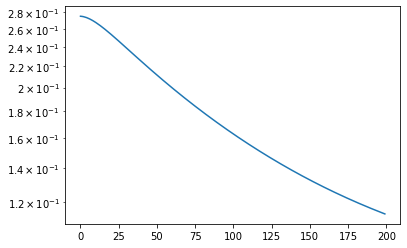

In [8]:
plt.plot([float(l['loss']) for l in loss_output])
plt.yscale('log')

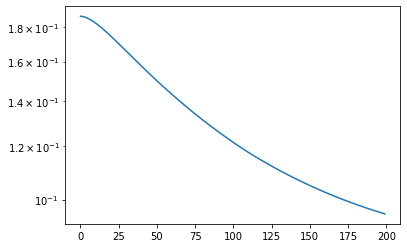

In [6]:
plt.plot([float(l['loss']) for l in loss_output])
plt.yscale('log')

In [5]:
y_train_pred = train.predict(trained_model, X_train[cols], y_train, device=device) # get predictions for each train
y_train_pred_df = pd.DataFrame(y_train_pred, columns=y_train.columns)  # put results into a dataframe
# y_test_pred = train.predict(trained_model, X_test[cols], y_test, device=device) # get predictions for each train
# y_test_pred_df = pd.DataFrame(y_test_pred, columns=y_test.columns)  # put results into a dataframe

# print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_test, y_test_pred_df)}')
# print(f'    Test set MSE (L2) loss: {mean_squared_error(y_test, y_test_pred_df)}')

random.seed(0)
#sample = random.sample(list(y_train_pred_df.index), 5)
sample = [0,1]

print("Train - Ground Truth (normalized):")
display(y_train.loc[sample])
print("Train - Ground Truth (non-normalized):")
display(clean_data.normalize_all_columns(y_train.loc[sample].copy(), reverse=True))  # see ground truths
print("Train - Prediction (normalized):")
display(y_train_pred_df.loc[sample])
print("Train - Prediction (non-normalized):")
display(clean_data.normalize_all_columns(y_train_pred_df.loc[sample].copy(), reverse=True))  # See predictions

Train - Ground Truth (normalized):


,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.409945,0.337814,0.028308,0.007366,0.993029,0.195022
1,0.409834,0.066217,0.028058,0.978702,0.021288,0.195969


Train - Ground Truth (non-normalized):


,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,73.7901,121.6130,0.007077,2.6519,357.4904,12.371379
1,73.7702,23.8382,0.007014,352.3327,7.6638,12.376819


Train - Prediction (normalized):


,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.390353,0.502573,0.043550,0.511284,0.489672,0.188558
1,0.404765,0.442349,-0.008086,0.510722,0.488479,0.211366


Train - Prediction (non-normalized):


,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,70.263496,180.926407,0.010887,184.062363,176.281982,12.334208
1,72.857666,159.245514,-0.002022,183.860016,175.852554,12.465356


In [19]:
def row_to_compare(X, y, y_pred, row):
    epoch = X.iloc[row].EPOCH_y
    X0 = clean_data.normalize_all_columns(X_train.iloc[row].copy(), reverse=True)
    y0 = clean_data.normalize_all_columns(y_train.iloc[row].copy(), reverse=True)
    y1 = clean_data.normalize_all_columns(y_train_pred_df.iloc[row].copy(), reverse=True)

    # Ground truth
    y0_xyz = clean_data.get_satellite_xyz(bst=0.0001,
                                          ecc=y0.ECCENTRICITY,
                                          aop=y0.ARG_OF_PERICENTER,
                                          inc=y0.INCLINATION,
                                          mea=y0.MEAN_ANOMALY,
                                          mem=y0.MEAN_MOTION,
                                          raa=y0.RA_OF_ASC_NODE,
                                          epoch=epoch,)
    # Prediction
    y1_xyz = clean_data.get_satellite_xyz(bst=0.0001,
                                          ecc=y1.ECCENTRICITY,
                                          aop=y1.ARG_OF_PERICENTER,
                                          inc=y1.INCLINATION,
                                          mea=y1.MEAN_ANOMALY,
                                          mem=y1.MEAN_MOTION,
                                          raa=y1.RA_OF_ASC_NODE,
                                          epoch=epoch,)
    # Propigation
    y2_xyz = clean_data.get_satellite_xyz(bst=X0.BSTAR,
                                          ecc=X0.ECCENTRICITY,
                                          aop=X0.ARG_OF_PERICENTER,
                                          inc=X0.INCLINATION,
                                          mea=X0.MEAN_ANOMALY,
                                          mem=X0.MEAN_MOTION,
                                          raa=X0.RA_OF_ASC_NODE,
                                          epoch=epoch,)
    print(f'Ground Truth: {y0_xyz}')
    print(f'Predicted: {y1_xyz}')
    print(f'Propigation: {y2_xyz}')
    
    print (f'Prediction Error: {sum((y1_xyz-y0_xyz)**2)**0.5} km')
    print (f'Propigation Error: {sum((y2_xyz-y0_xyz)**2)**0.5} km')
    

for row in range(2):
    print (f'Row {row}:')
    row_to_compare(X_train, y_train, y_train_pred_df, row)
    print('')

Row 0:
Ground Truth: [-4.11141422e+03  6.67947009e+03  2.55887754e-01]
Predicted: [-4.11066867e+03  6.67993360e+03 -7.11411195e-01]
Propigation: [ 7.85016858e+03 -6.54560438e+01  3.25070548e-02]
Prediction Error: 1.30627429652818 km
Propigation Error: 13732.206362207282 km

Row 1:
Ground Truth: [7.17304819e+03 3.16940935e+03 1.18593311e-02]
Predicted: [ 7.17312896e+03  3.16922246e+03 -7.80126081e-01]
Propigation: [-4.11141422e+03  6.67947009e+03  2.55887198e-01]
Prediction Error: 0.8177376661757888 km
Propigation Error: 11817.767056373674 km

